# Modelling and filtering vs filtering wavelet and modelling

## Author: M. Ravasi

This notebook is aimed at validating the procedures implemented in the ``devitofwi.preproc.filtering.Filter`` object to perform filtering of data. More precisely we want to check that the following two filtering procedures lead to the same output data:

    - Modelling of data with unfiltered wavelet + Filtering of data
    - Filtering of wavelet + Modelling of data with filtered wavelet 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfiltfilt, correlate, freqs
from scipy.ndimage import gaussian_filter
from pylops.utils.tapers import taper

from devito import configuration
from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.utils import clear_devito_cache
from devitofwi.preproc.filtering import filter_data, Filter
from devitofwi.waveengine.acoustic import AcousticWave2D

configuration['log-level'] = 'ERROR'

In [2]:
clear_devito_cache()

## Parameters 

In [3]:
# Model and aquisition parameters
par = {'nx':601,   'dx':15,    'ox':0,
       'nz':221,   'dz':15,    'oz':0,
       'ns':1,     'ds':300,   'os':4000,  'sz':0,
       'nr':300,   'dr':30,    'or':0,     'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':15,
       'niters': 5
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

# Filtering parameters
nfilt = 7
fmax = 7
ntap = 200
nfft = 2**10

## Acquisition set-up

In [4]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1] * 1e3 # in ms

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

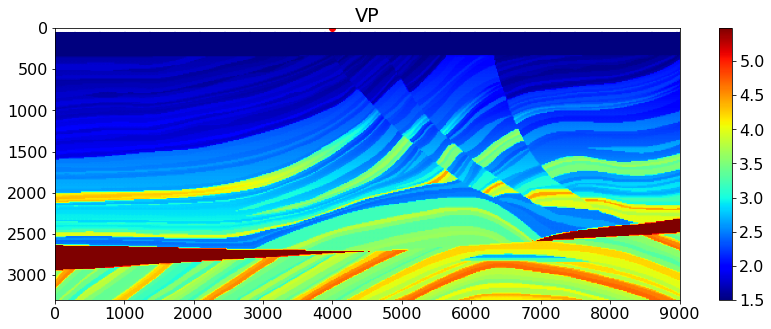

In [5]:
# Function to get water layer mask
def mask(m, value):
    """Mask for model below given value
    """
    msk = m > value
    msk = msk.astype(int)
    return msk

# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = mask(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('VP')
plt.axis('tight');

## Data modelling

In [6]:
# Define modelling engine
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vp=vp_true * 1e3, 
                      src_type='Ricker', f0=par['freq'],
                      space_order=space_order, nbl=nbl)

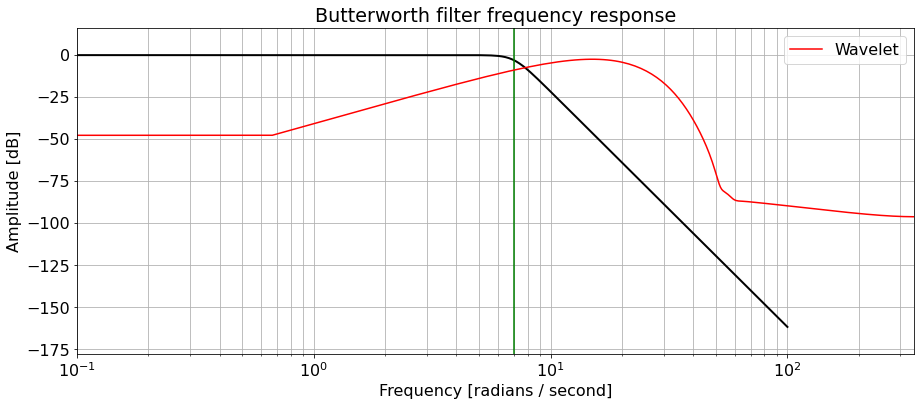

In [7]:
# Creating filtering object
f = np.fft.rfftfreq(nfft, amod.geometry.dt * 1e-3)
wav = amod.geometry.src.wavelet
WAV = np.fft.rfft(wav, nfft)

plt.figure(figsize=(15, 6))
Filt = Filter([fmax, ], [nfilt, ], amod.geometry.dt * 1e-3, plotflag=True)
plt.semilogx(f, 20*np.log10(np.abs(WAV)) - 28, 'r', label='Wavelet')
plt.legend()

# Find optimal padding to apply such that lowest freq wavelet does not become acausal
wav = amod.geometry.src.wavelet
wavpad = Filt.find_optimal_t0(wav, pad=700, thresh=1e-3)

# Pad wavelet with optimal wavpad
wav = np.pad(wav, (wavpad, 0))[:-wavpad]

# Filter wavelet
wavfilt = Filt.apply_filter(wav.squeeze(), ifilt=0)

In [8]:
# Model data with original wavelet
dobs = amod._mod_allshots().squeeze()

# Pad observed data
dobs = np.pad(dobs.T, ((0,0), (wavpad, 0)))[:, :-wavpad].T

# Filter data
dobsfilt = Filt.apply_filter(dobs.T, ifilt=0).T

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Model data with filtered wavelet
amod.wav = wavfilt
dobswavfilt = amod._mod_allshots().squeeze()

  0%|          | 0/1 [00:00<?, ?it/s]

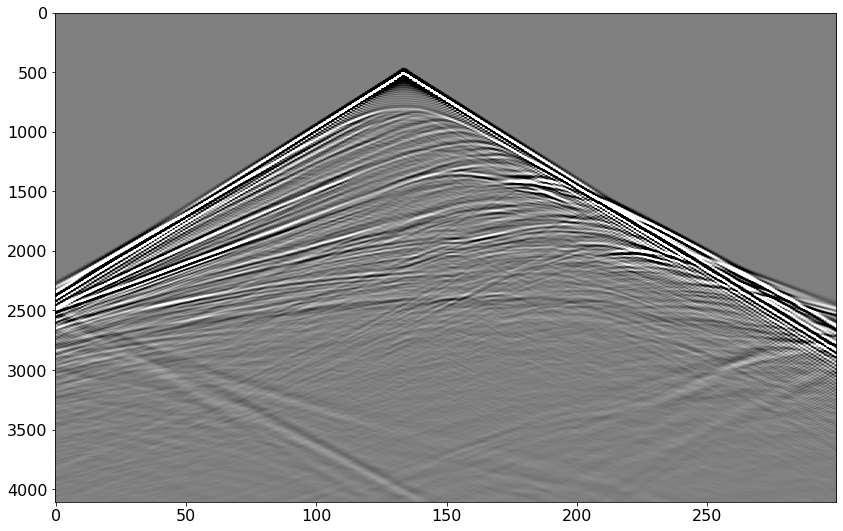

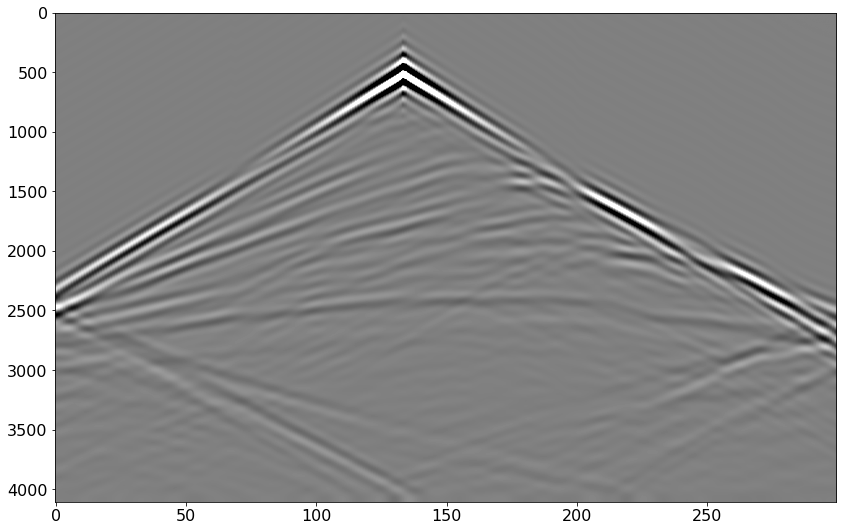

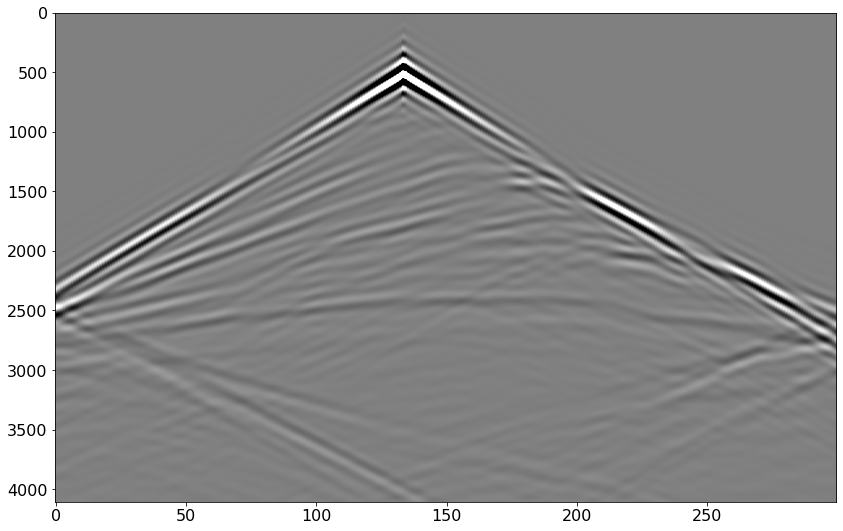

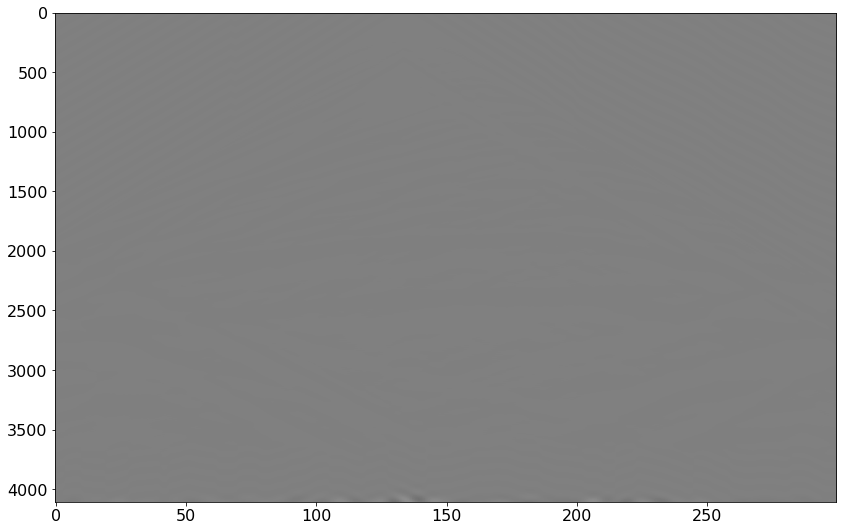

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobs, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax)

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobsfilt, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax)

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobswavfilt, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax);

fig, ax = plt.subplots(1, 1, figsize=(14, 9))
ax.imshow(dobsfilt-dobswavfilt, aspect='auto', cmap='gray',
          vmin=-d_vmax, vmax=d_vmax);